##  Centroid Estimation - Scikit learn and Tensorflow
Here I use the spot images that were classified in the previous notebook using SVM for estimation of their centroid location.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sympy
import tensorflow as tf
from time import time

In [2]:
# The dataset was pickled. It is a Bunch object.
with open('spot_image_data.pkl','rb') as fid:
    image = pickle.load(fid)

In [3]:
image.data.shape

(3215, 81)

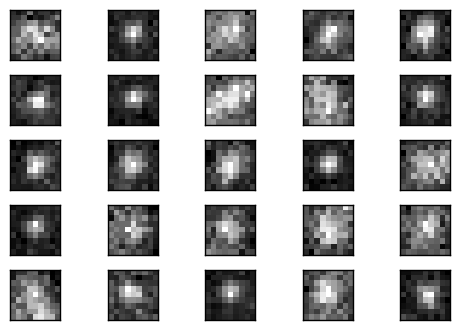

In [4]:
# Plotting few images from overall dataset
pix = 9
fig, axes = plt.subplots(5,5)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

for i, ax in enumerate(axes.flat):
    ax.matshow(image.data[i].reshape(pix,pix),cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

In [5]:
image.target[:5]

0    False
1     True
2    False
3     True
4    False
Name: target, dtype: bool

In [6]:
#Selecting the spots that were classified as good.
good_im = image.data[image.target]

In [7]:
#Selecting the fit parameters of the spots.
#These were obtained by fitting to a 2D Gaussian.
good_par = image.fit_params.loc[image.target,['Amp','xc','yc','sigx','sigy','offset']]

In [8]:
good_par.head()

,Amp,xc,yc,sigx,sigy,offset
1,1374.380229,3.990416,3.673524,1.051023,1.115426,1240.530749
3,745.852520,4.293561,3.974905,1.169750,1.474255,1154.388030
5,1253.269560,4.452955,4.375621,1.164321,1.017014,1283.164215
6,1456.702499,4.159699,3.702994,1.171062,1.010953,1245.558466
9,1225.947609,4.110754,3.551222,1.127565,1.231370,1202.746821


In [9]:
#Dimension of the data and te target
good_im.shape,good_par.shape

((2047, 81), (2047, 6))

Below I use ridge regression for estimation of the centroid.

In [10]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn import metrics
from sklearn.model_selection import train_test_split

#Regressor
regr = Ridge(fit_intercept=True,normalize=True,alpha=0.01,solver='auto')

#Splitting the dataset into training and test dataset
Xr_train,Xr_test, yr_train, yr_test = train_test_split(good_im,good_par,test_size = 0.2)

#Fitting the data and prediction
regr.fit(Xr_train,yr_train)
t0 = time()
test_pred = regr.predict(Xr_test)
total_time = time()-t0
print ("Total time taken = {} sec".format(total_time))
print ("Time per spot = {} sec".format(total_time/yr_test.shape[0]))
diff = test_pred - yr_test


Total time taken = 0.0008008480072021484 sec
Time per spot = 1.9532878224442646e-06 sec


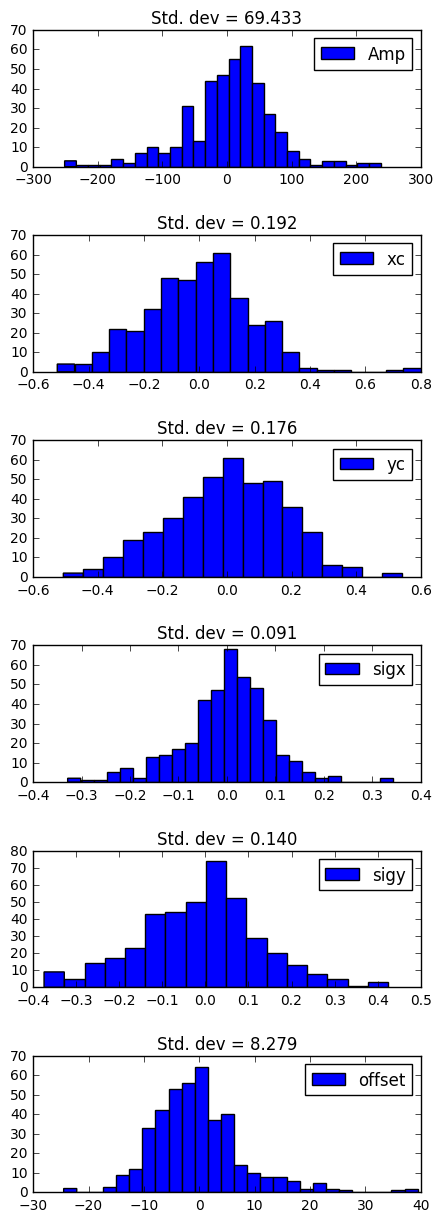

In [11]:
fig, axes = plt.subplots(6,1,figsize=(5,15))
fig.subplots_adjust(hspace=0.5)

for i,ax in zip(diff.columns,axes.flat):
    ax.hist(diff[i],bins='auto')
    ax.legend()
    ax.set_title('Std. dev = {:.3f}'.format(np.std(diff[i])))

## Linear Regression in Tensorflow
I am trying only for the xc values.

In [12]:
def norm_input(features):
    mu = np.mean(features,axis=0)
    sigma = np.std(features,axis=0)
    return (features-mu)/sigma

In [13]:
#Defining the features and targets
features = good_im # All the good images
target = good_par.xc.values # xc values for all the good images

features = norm_input(features)
#Adding 1 (bias term) to the features. Will increase the number of feature by 1. 
f = np.c_[np.ones(good_im.shape[0]),features].astype(np.float32)
f1=np.reshape(f,[good_im.shape[0],good_im.shape[1]+1])

In [14]:
print ("The number of images in the dataset = {}".format(f1.shape[0]))
print ("The number of feature in each image = {}".format(f1.shape[1]))

The number of images in the dataset = 2047
The number of feature in each image = 82


In [15]:
#Reshaping the target shape from (2359,) to (2359,1)
tar = np.reshape(target,[target.shape[0],1]).astype(np.float32)
tar.shape

(2047, 1)

## Setting up the machinery for tensorflow

In [16]:
#Placeholder for the input features and targets
X = tf.placeholder(tf.float32,[None,f1.shape[1]])
y = tf.placeholder(tf.float32,[None,1])

#Weights to be used
W = tf.Variable(tf.ones([f1.shape[1],1]))

#Predictions
y_pred = tf.matmul(X,W)


#Optimization routine - Mean squared error
cost = tf.reduce_mean(tf.square(y_pred-y))
optimizer = tf.train.AdamOptimizer(0.1).minimize(cost)

### Running the optimization


Total time taken = 0.0010650157928466797 sec
Time per spot = 4.329332491246666e-06 sec
0.176545


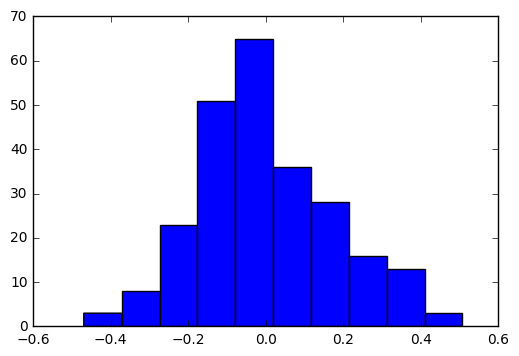

In [17]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    cost1 = []
    for epoch in range (1000):
        sess.run(optimizer,feed_dict = {X:f1[:1800],y:tar[:1800]})
        tmp = sess.run(cost,feed_dict = {X:f1[:1800],y:tar[:1800]})
        cost1.append(tmp)
    #plt.plot(cost1)
    t0 = time()
    predictions = sess.run(y_pred,feed_dict={X:f1[1801:],y:tar[1801:]})
    t1 = time()
    total_time = t1-t0
    print ("Total time taken = {} sec".format(total_time))
    print ("Time per spot = {} sec".format(total_time/tar[1801:].shape[0]))
    #print (predictions)
    diff = tar[1801:]-predictions
    plt.hist(diff)  
    print (diff.std())



Std Dev of 0.176 pixel is better than what we obtained with Ridge Regression (0.192 pixel).

Although linear regression using tensorflow is slightly slower than ridge regression (4.33e-06 v/s 1.95e-06 sec/spot), both of them are significantly faster than the traditional Gaussian fitting approach (9577.27e-06 sec/spot).

### This shows that implementation of machine learning can easily allow real time analysis of super-resolution data.


I have also noticed that rather than using the original data as input, if the pixel values are attenuate by taking their nth root (below I am using 1/4) reduces the variation in the data, and helps achieve better estimation of the centroid.

For the power of 1/4, I get Std Dev of 0.13 pixel and this is achieved at 3.95e-06 sec/spot!


In [18]:
feature1 = good_im
feature1 = norm_input(np.power(feature1,1/4))


#Adding 1 (bias term) to the features. Will increase the number of feature by 1. 
f = np.c_[np.ones(good_im.shape[0]),feature1].astype(np.float32)
f1=np.reshape(f,[good_im.shape[0],good_im.shape[1]+1])

Total time taken = 0.0009720325469970703 sec
Time per spot = 3.951351817061262e-06 sec
0.1303


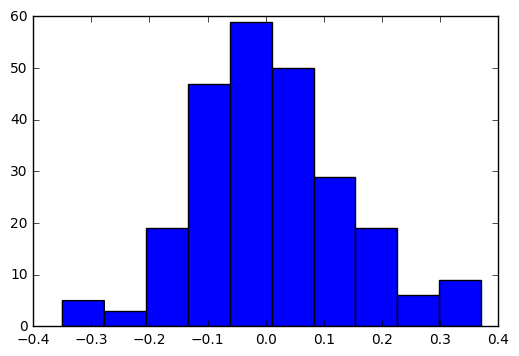

In [19]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    cost1 = []
    for epoch in range (1000):
        sess.run(optimizer,feed_dict = {X:f1[:1800],y:tar[:1800]})
        tmp = sess.run(cost,feed_dict = {X:f1[:1800],y:tar[:1800]})
        cost1.append(tmp)
    #plt.plot(cost1)
    t0 = time()
    predictions = sess.run(y_pred,feed_dict={X:f1[1801:],y:tar[1801:]})
    t1 = time()
    total_time = t1-t0
    print ("Total time taken = {} sec".format(total_time))
    print ("Time per spot = {} sec".format(total_time/tar[1801:].shape[0]))
    #print (predictions)
    diff = tar[1801:]-predictions
    plt.hist(diff)  
    print (diff.std())